### Bibliotecas

In [1]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [3]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [4]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [6]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [7]:
dataset_dados['horario'] = dataset_dados['horario'].fillna('99:99:99')

In [8]:
dataset_dados = dataset_dados.assign(dia_semana=dataset_dados['data'].dt.weekday, hora=dataset_dados['horario'].astype('str').str.slice(stop=2).astype('int').replace({99:np.nan}),
                     minuto=dataset_dados['horario'].astype('str').str.slice(start=3, stop=5).astype('int').replace({99:np.nan}))
dataset_dados['horario'] = dataset_dados['horario'].replace({'99:99:99':np.nan})

In [9]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [10]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [12]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [13]:
dataset_dados = dataset_dados.assign(resultado_partida=dataset_dados['resultado_temporario'].map(lambda x: 0 if x == 0 else 1 if x > 0 else -1))

In [14]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [15]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [17]:
#RESULTADOS CONSECUTIVOS

dataset_consec = dataset_dados['resultado_partida'].shift(5, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_consec[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

dataset_ultimo = dataset_dados['resultado_partida'].shift(1, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_ultimo[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

del dataset_consec, dataset_ultimo

##### Gols, Colocação e Time Adversário

In [19]:
dataset_dados.loc[:,['gols_botafogo','colocacao_botafogo','colocacao_adversario','time_adversario']] = dataset_dados.apply(lambda d: d[['gols_mandante','colocacao_mandante','colocacao_visitante','time_visitante']].rename(index={'gols_mandante':'gols_botafogo','colocacao_mandante':'colocacao_botafogo','colocacao_visitante':'colocacao_adversario','time_visitante':'time_adversario'})
                            if d['time_mandante'] == 'Botafogo' 
                            else d[['gols_visitantes','colocacao_visitante','colocacao_mandante','time_mandante']].rename(index={'gols_visitantes':'gols_botafogo','colocacao_visitante':'colocacao_botafogo','colocacao_mandante':'colocacao_adversario','time_mandante':'time_adversario'}), axis=1)

In [20]:
dataset_gols = dataset_dados['gols_botafogo'].shift(5, fill_value=0)
for i in range(len(dataset_dados)):
    valor = dataset_gols[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor
del dataset_gols

##### Percentual de Ocupacao

In [22]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [24]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [26]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [28]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [34]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [43]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

##### Distância dos Dias entre o Último Jogo em Casa

In [47]:
dataset_dados['data_ultimo_jogo'] = dataset_dados['data'].shift(1)

In [50]:
dataset_dados.loc[0,'data_ultimo_jogo'] = pd.to_datetime('2022-03-07')

In [54]:
dataset_dados.loc[:, 'dias_ultimo_jogo_casa'] = (dataset_dados['data'] - dataset_dados['data_ultimo_jogo']).dt.days

##### Tratamentos

In [57]:
len(dataset_dados)

93

In [58]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida', 'publico',
       'publico_max', 'arrecadacao', 'despesas', 'impostos',
       'resultado_financeiro', 'custo_botafogo', 'anunciou_poupar',
       'time_mandante', 'time_visitante', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'desfalques', 'colocacao_mandante',
       'colocacao_visitante', 'gols_mandante', 'gols_visitantes', 'dia_semana',
       'hora', 'minuto', 'mes', 'dia_mes', 'resultado_temporario',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro', 'data_ultimo_jogo',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [62]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario', 'data_ultimo_jogo'])

In [64]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida',
       'anunciou_poupar', 'estado_adversario', 'classico', 'eliminatorio',
       'tecnico_botafogo', 'desfalques', 'dia_semana', 'hora', 'minuto', 'mes',
       'dia_mes', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [67]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [70]:
len(dataset_dados.columns)

31

In [73]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario',
                                                       'tecnico_botafogo', 'time_adversario', 'fase'])

In [75]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [77]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [79]:
len(dataset_dados)

84

##### Normalizações com Substituição por IQR e Box-Cox

In [82]:
listaColunas = ['ano_campeonato', 'temperatura', 'jogos_no_mes', 'rodada', 'desfalques', 'dia_semana', 'hora', 'mes', 'dia_mes', 'colocacao_botafogo',
                'colocacao_adversario', 'gols_botafogo_ultimos_jogos', 'dias_ultimo_jogo_casa']

In [84]:
for i in listaColunas:
    
    if stats.shapiro(dataset_dados[i])[1] < 0.05:
    
        quartilUm = np.percentile(dataset_dados[i], 25)
        quartilTres = np.percentile(dataset_dados[i], 75)
        iqr = (quartilTres - quartilUm) * 1.5
        lim_superior = quartilTres + iqr
        lim_inferior = quartilUm - iqr
        
        dataset_dados.loc[dataset_dados[dataset_dados[i] > lim_superior].index, i] = lim_superior
        dataset_dados.loc[dataset_dados[dataset_dados[i] < lim_inferior].index, i] = lim_inferior
    
        if stats.shapiro(dataset_dados[i])[1] < 0.05:

            dataset_dados.loc[dataset_dados[dataset_dados[i] <= 0].index, i] = 0.0000001
            dataset_dados[i] = stats.boxcox(dataset_dados[i])[0]

##### Min Max Scaler

In [87]:
for i in listaColunas:
    scaler = MinMaxScaler()
    dataset_dados[i] = scaler.fit_transform(dataset_dados[[i]])

In [89]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [93]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [97]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [99]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [101]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [103]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [106]:
def tunning_hiperpametros (modelo, X_train, y_train):
    
    print('Testando Variáveis: max_depth, min_child_weight')
    
    param_test = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2),
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
        
    max_depth = gsearch.best_params_['max_depth']
    min_child_weight = gsearch.best_params_['min_child_weight']
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis:gamma')
    
    param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = 0 , subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    gamma = gsearch.best_params_['gamma']
    
    print('-----------------------------')  
    
    print('Testando Variáveis: subsample, colsample_bytree')
    
    param_test = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis: reg_alpha')
    
    param_test = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = gsearch.best_params_['subsample'],
                    colsample_bytree = gsearch.best_params_['colsample_bytree'], scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  

##### Modelo 1

In [109]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    84.000000
mean     45.863690
std      23.417999
min       8.140000
25%      28.237500
50%      42.865000
75%      63.942500
max      91.780000
Name: percentual_ocupacao, dtype: float64


In [111]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca              -0.547026
estado_adversario_RJ            -0.378938
temperatura                     -0.346926
time_adversario_Portuguesa-RJ   -0.307082
anunciou_poupar                 -0.288306
mando_vendido_compartilhado     -0.288186
estádio_Raulino de Oliveira     -0.250271
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao                1.000000
mes                                0.469250
campeonato_serie a                 0.351781
tecnico_botafogo_Bruno Lage        0.343006
rodada                             0.283972
tecnico_botafogo_Cláudio Caçapa    0.234355
estádio_Nilton Santos              0.231691
Name: percentual_ocupacao, dtype: float64


In [113]:
dados_modelo_percentual_ocupacao.corr()['percentual_ocupacao']

ano_campeonato               -0.024575
temperatura                  -0.346926
jogos_no_mes                 -0.084011
rodada                        0.283972
anunciou_poupar              -0.288306
                                ...   
fase_quartas-de-final         0.037469
fase_segunda fase            -0.093893
fase_semi-final              -0.131622
fase_semi-final - taça rio   -0.241147
fase_terceira fase           -0.019343
Name: percentual_ocupacao, Length: 115, dtype: float64

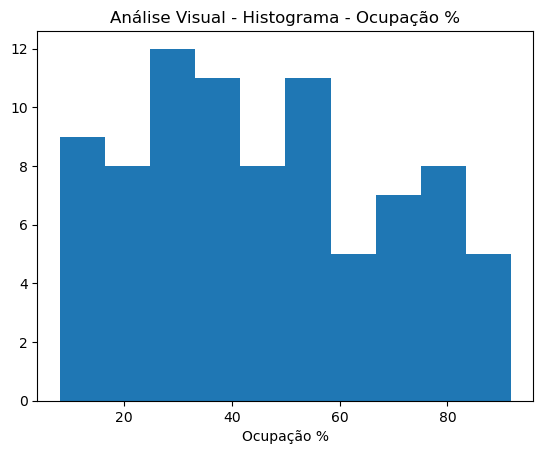

In [115]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [118]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     46
False    38
Name: count, dtype: int64


In [120]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
temperatura                     -0.400751
campeonato_carioca              -0.375615
anunciou_poupar                 -0.350962
eliminatorio                    -0.341418
tipo_partida_volta              -0.330599
time_adversario_Portuguesa-RJ   -0.211741
estádio_Luso Brasileiro         -0.211741
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro         1.000000
tipo_partida_liga      0.341418
rodada                 0.336500
mes                    0.329091
campeonato_serie a     0.324516
fase_fase de grupos    0.252082
classico               0.237518
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [123]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1    45
-1    22
 0    17
Name: count, dtype: int64


In [125]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
tecnico_botafogo_Lúcio Flávio   -0.361217
time_adversario_Flamengo        -0.288376
rodada                          -0.253215
classico                        -0.247411
time_adversario_Cuiabá-MT       -0.234018
estado_adversario_MT            -0.234018
mes                             -0.212380
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida              1.000000
resultados_ultimo_jogo         0.585191
ano_campeonato                 0.312189
gols_botafogo_ultimos_jogos    0.278859
minuto                         0.256856
jogos_no_mes                   0.247548
eliminatorio                   0.207214
Name: resultado_partida, dtype: float64


### Modelagem

##### Modelo 1

In [129]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [131]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [133]:
tunning_hiperpametros(XGBRegressor, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [135]:
model = XGBRegressor(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.0, subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05, early_stopping_rounds=10, eval_metric='rmse')
model.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-rmse:22.11041
[1]	validation_0-rmse:22.02380
[2]	validation_0-rmse:21.91853
[3]	validation_0-rmse:21.84335
[4]	validation_0-rmse:21.75946
[5]	validation_0-rmse:21.73794
[6]	validation_0-rmse:21.58519
[7]	validation_0-rmse:21.47273
[8]	validation_0-rmse:21.49452
[9]	validation_0-rmse:21.44231
[10]	validation_0-rmse:21.34837
[11]	validation_0-rmse:21.25940
[12]	validation_0-rmse:21.19371
[13]	validation_0-rmse:21.07589
[14]	validation_0-rmse:20.98094
[15]	validation_0-rmse:21.00296
[16]	validation_0-rmse:20.89987
[17]	validation_0-rmse:20.88642
[18]	validation_0-rmse:20.83339
[19]	validation_0-rmse:20.75642
[20]	validation_0-rmse:20.67664
[21]	validation_0-rmse:20.54889
[22]	validation_0-rmse:20.54629
[23]	validation_0-rmse:20.48636
[24]	validation_0-rmse:20.51551
[25]	validation_0-rmse:20.48800
[26]	validation_0-rmse:20.41185
[27]	validation_0-rmse:20.33374
[28]	validation_0-rmse:20.26475
[29]	validation_0-rmse:20.18811
[30]	validation_0-rmse:20.11964
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [137]:
model.feature_importances_

array([9.58626252e-03, 9.98505205e-03, 7.25242309e-03, 1.50976004e-02,
       9.99721605e-03, 1.05330953e-02, 1.42045813e-02, 1.04965763e-02,
       1.81155708e-02, 1.62753463e-02, 1.38437767e-02, 2.96219047e-02,
       1.31631233e-02, 1.19422898e-02, 9.46610514e-03, 2.23371070e-02,
       1.14711253e-02, 1.69805773e-02, 7.56400600e-02, 1.65238511e-02,
       5.12813441e-02, 1.17895193e-02, 1.19385626e-02, 4.51284796e-02,
       7.99523108e-03, 0.00000000e+00, 0.00000000e+00, 5.48932655e-03,
       1.33684068e-03, 9.89272818e-03, 0.00000000e+00, 0.00000000e+00,
       1.17337285e-02, 0.00000000e+00, 2.93947421e-02, 1.80924777e-02,
       8.20097141e-03, 1.01527721e-02, 4.67817625e-03, 0.00000000e+00,
       0.00000000e+00, 1.32480999e-02, 9.30638285e-04, 0.00000000e+00,
       0.00000000e+00, 1.05543137e-02, 0.00000000e+00, 0.00000000e+00,
       2.97886482e-03, 7.88973831e-03, 1.73423663e-02, 0.00000000e+00,
       0.00000000e+00, 1.76127367e-02, 1.12376586e-02, 1.44888889e-02,
      

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

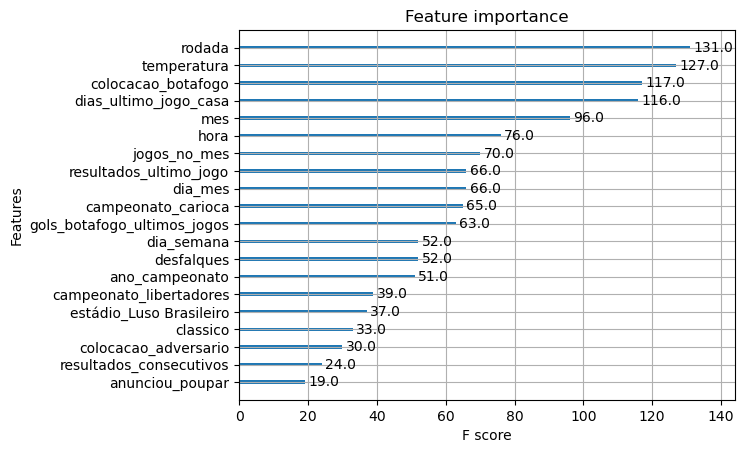

In [139]:
plot_importance(model, max_num_features=20)

In [141]:
score = model.score(X_train, y_train)  
score

0.8217873962791512

In [143]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

17

Text(0.5, 1.0, 'Previsão Ocupação')

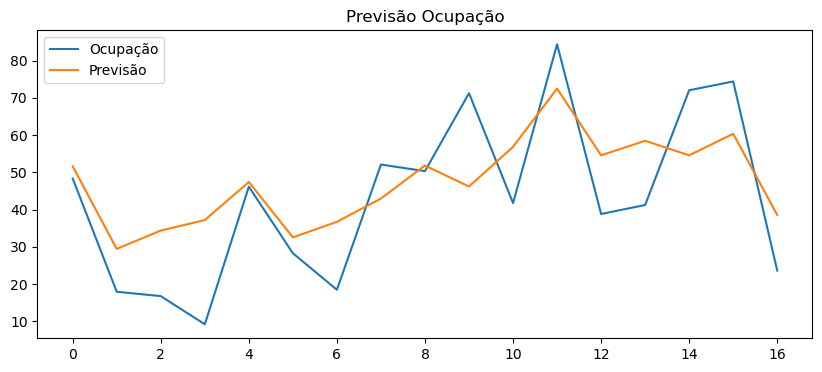

In [145]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [147]:
taxas_erro(y_test, predictions)

Erro médio quadrático:  15.221990980828336
Erro médio absoluto:  13.304706358068131


##### Previsões

In [149]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [151]:
model.predict(dataset_previsao_modelo)

array([46.967506], dtype=float32)

##### Modelo 2

In [153]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [155]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [159]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.2}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.8, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 0.1}
-----------------------------


In [163]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=5, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.2, subsample = 0.8, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 0.1, early_stopping_rounds=10, eval_metric='auc')

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-auc:0.68056
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.75000
[3]	validation_0-auc:0.71528
[4]	validation_0-auc:0.72917
[5]	validation_0-auc:0.70833
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72222
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.73611
[11]	validation_0-auc:0.76389
[12]	validation_0-auc:0.80556
[13]	validation_0-auc:0.80556
[14]	validation_0-auc:0.79167
[15]	validation_0-auc:0.76389
[16]	validation_0-auc:0.77778
[17]	validation_0-auc:0.77778
[18]	validation_0-auc:0.77778
[19]	validation_0-auc:0.77778
[20]	validation_0-auc:0.79167
[21]	validation_0-auc:0.80556


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [165]:
model.feature_importances_

array([0.04097378, 0.0524748 , 0.04074099, 0.04927887, 0.08518038,
       0.08475859, 0.06083284, 0.02892289, 0.03385065, 0.05166549,
       0.00399232, 0.06880274, 0.03721683, 0.02275238, 0.01808751,
       0.05848041, 0.02404367, 0.02609427, 0.02648608, 0.04445932,
       0.07957121, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06133395,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

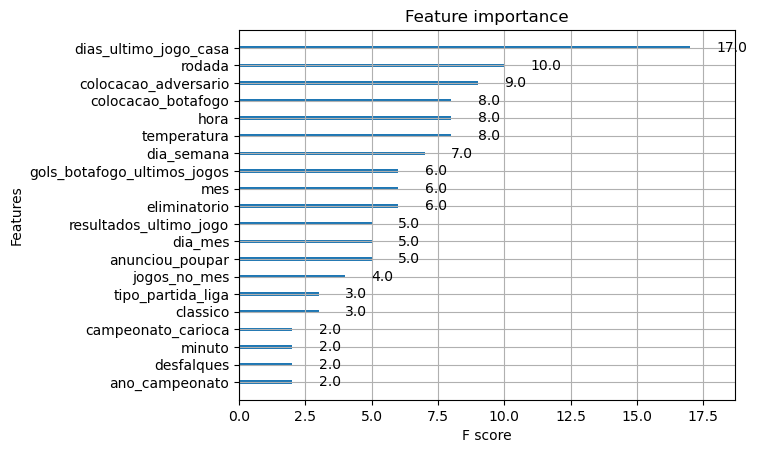

In [167]:
plot_importance(model, max_num_features=20)

In [169]:
score = model.score(X_train, y_train)  
score

0.5522388059701493

In [171]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

17

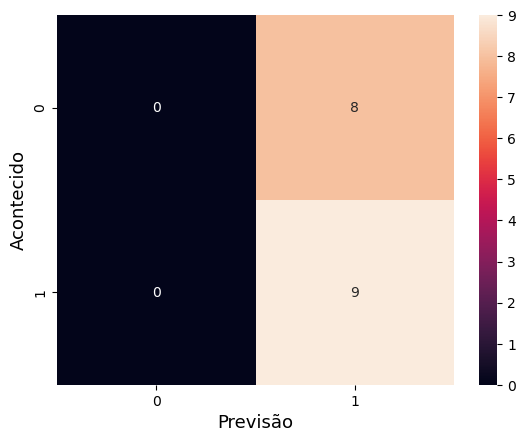

In [173]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [175]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         8
        True       0.53      1.00      0.69         9

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17



##### Previsões

In [178]:
model.predict(dataset_previsao_modelo)

array([1])

##### Modelo 3

In [181]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [183]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [185]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [189]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [191]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0., subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05, early_stopping_rounds=10, eval_metric='auc')

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-auc:0.77042
[1]	validation_0-auc:0.76021
[2]	validation_0-auc:0.83007
[3]	validation_0-auc:0.84600
[4]	validation_0-auc:0.84232
[5]	validation_0-auc:0.91054
[6]	validation_0-auc:0.90319
[7]	validation_0-auc:0.91993
[8]	validation_0-auc:0.94322
[9]	validation_0-auc:0.93668
[10]	validation_0-auc:0.93668
[11]	validation_0-auc:0.93301
[12]	validation_0-auc:0.93954
[13]	validation_0-auc:0.93954
[14]	validation_0-auc:0.93301
[15]	validation_0-auc:0.93301
[16]	validation_0-auc:0.93301
[17]	validation_0-auc:0.92933


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [193]:
model.feature_importances_

array([0.0505297 , 0.02743568, 0.03516024, 0.03869572, 0.02668569,
       0.05654775, 0.        , 0.02475419, 0.04139761, 0.02283338,
       0.04883489, 0.03247573, 0.04024858, 0.03958751, 0.05897402,
       0.02984545, 0.03004729, 0.03364521, 0.03954891, 0.03455172,
       0.        , 0.        , 0.03980064, 0.        , 0.04109431,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0300012 ,
       0.        , 0.        , 0.        , 0.00719489, 0.00289815,
       0.02147336, 0.        , 0.00916761, 0.04080865, 0.        ,
       0.0369656 , 0.        , 0.04581789, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

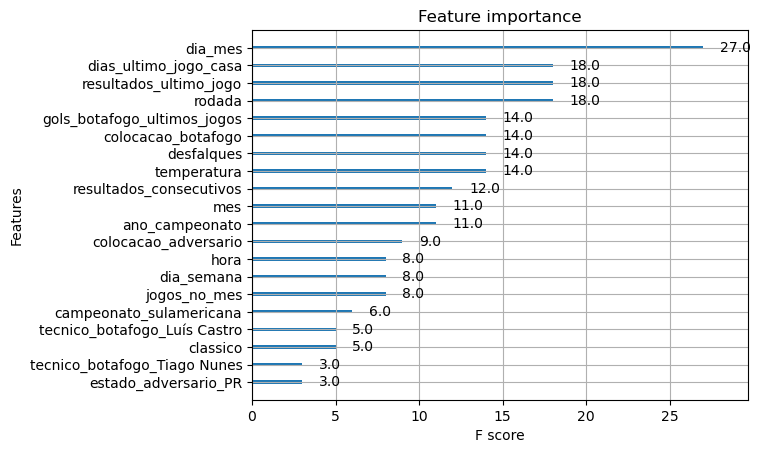

In [195]:
plot_importance(model, max_num_features=20)

In [197]:
score = model.score(X_train, y_train)  
score

0.835820895522388

In [199]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

17

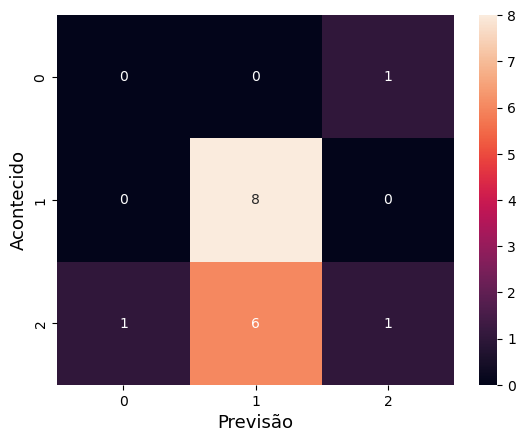

In [201]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [203]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.57      1.00      0.73         8
           2       0.50      0.12      0.20         8

    accuracy                           0.53        17
   macro avg       0.36      0.38      0.31        17
weighted avg       0.50      0.53      0.44        17



##### Previsões

In [205]:
model.predict(dataset_previsao_modelo)

array([1], dtype=int64)